In [37]:


import numpy as np
import cv2

# Load the .npy file
# Replace 'your_file.npy' with the actual path to your .npy file
data = np.load('/Users/henryschnieders/Documents/Research/My_work/Current_Summary/Starting_4_5_2025/Data/test415_545_regions.npy', allow_pickle=True)




# If the array is not already in uint8 format (0-255), convert it
# This assumes the data is a 2D or 3D numpy array

# If the array is 2D (grayscale), convert to 3-channel for display

#image = cv2.cvtColor(np.array(data[0][1], dtype = np.int64), cv2.COLOR_GRAY2BGR)
# If the array is in RGB format but not BGR (OpenCV uses BGR), convert it



In [38]:
data[0][2]

array([[[525, 433, 465],
        [545, 452, 487],
        [555, 463, 497],
        [567, 475, 509],
        [575, 483, 517],
        [592, 499, 540],
        [611, 518, 559],
        [618, 524, 568],
        [615, 522, 565],
        [618, 523, 573]],

       [[546, 454, 487],
        [565, 473, 509],
        [572, 480, 516],
        [579, 487, 523],
        [584, 492, 528],
        [598, 505, 548],
        [613, 520, 563],
        [619, 525, 570],
        [618, 524, 569],
        [620, 525, 578]],

       [[562, 470, 503],
        [577, 485, 521],
        [579, 487, 523],
        [581, 488, 524],
        [582, 490, 525],
        [591, 498, 541],
        [603, 509, 552],
        [605, 511, 557],
        [610, 516, 561],
        [615, 521, 573]],

       [[568, 476, 509],
        [578, 486, 521],
        [578, 486, 521],
        [576, 484, 518],
        [575, 483, 517],
        [583, 490, 531],
        [595, 501, 543],
        [599, 506, 550],
        [607, 514, 558],
        [618, 523, 

In [39]:
#def motion_process_5regions(data):
    #data = list list of 5 np arrays
    
    #--------------------

    # Temporal normalization

    #--------------------

    # use a 10-frame window

    
def complex_mag(arr):
    return np.absolute(arr)



In [40]:
import numpy as np

def motion_process_5regions(data, window_size=10, phi_tol=0.8):
    """
    Processes motion across 5 regions by temporally normalizing the input data,
    computing frame-to-frame differences, and masking out pixels that do not meet
    an arbitrary phi tolerance criterion computed between consecutive motion differences.

    Parameters:
      data (list of np.ndarray): List of 5 NumPy arrays, each of shape (T, H, W, 3)
                                  representing image sequences.
      window_size (int): Number of frames over which to perform temporal normalization.
      phi_tol (float): Arbitrary phi tolerance threshold. For a given pixel,
                       if the phi value computed between consecutive differences is
                       lower than this threshold, the pixel is masked (set to 0).

    Returns:
      motion_data (list of np.ndarray): List of 5 NumPy arrays (shape (T, H, W, 3))
                                        containing motion-filtered images.
      phi_bitmask (list of list of np.ndarray): For each region, a list of bitmask arrays
                                        (each of shape (H, W)) where a value of 1 indicates
                                        the phi at that pixel is >= phi_tol and a 0 indicates
                                        otherwise.
      phi_tol (float): The phi tolerance value used.
    """

    # List to store motion data for each region.
    motion_data = []
    # List to store phi bitmask for each region.
    phi_bitmask = []
    
    # Process each region separately.
    for region_array in data:
        T, H, W, C = region_array.shape
        # Create a working copy of the region data.
        region = region_array.copy().astype(np.float32)

        #--------------------
        # Temporal normalization using a 10-frame window.
        #--------------------
        for t in range(T):
            start = max(0, t - window_size + 1)
            end = t + 1  # window covers frames [start, ..., t]
            window = region[start:end]  # shape: (window_length, H, W, 3)
            mean_val = window.mean(axis=(0, 1, 2), keepdims=True)
            std_val = window.std(axis=(0, 1, 2), keepdims=True) + 1e-8  # avoid division by zero
            region[t] = (region[t] - mean_val) / std_val

        #--------------------
        # Compute pixel motion filtering (frame differences).
        #--------------------
        motion = np.zeros_like(region)
        # For each frame t (except the last one) compute difference: I[t+1] - I[t]
        for t in range(T - 1):
            motion[t] = region[t + 1] - region[t]
        # Note: motion[T-1] remains zeros.

        #--------------------
        # Compute phi between consecutive motion differences and create bitmasks.
        # We compute phi for indices where two consecutive difference frames exist,
        # i.e., for t in range(T-2) using differences at frames t and t+1.
        # Also, apply the bitmask to the second difference frame.
        #--------------------
        region_masks = []  # List to store the bitmask arrays for this region.
        for t in range(T - 2):
            C_t = motion[t]
            C_t1 = motion[t + 1]
            
            # Normalize the difference vectors on a per-pixel basis.
            norm_C_t = np.linalg.norm(C_t, axis=-1, keepdims=True) + 1e-8
            norm_C_t1 = np.linalg.norm(C_t1, axis=-1, keepdims=True) + 1e-8
            C_t_normalized = C_t / norm_C_t
            C_t1_normalized = C_t1 / norm_C_t1
            
            # Compute phi as the dot product along the channel axis.
            phi = np.sum(C_t_normalized * C_t1_normalized, axis=-1)  # shape: (H, W)
            
            # Create a bitmask: set pixel to 1 if phi meets/exceeds tolerance, else 0.
            mask = (phi >= phi_tol).astype(np.uint8)
            region_masks.append(mask)
            
            # Apply the bitmask to the corresponding motion frame (frame t+1):
            # For each pixel where mask is 0, set the motion data to 0.
            expanded_mask = np.expand_dims(mask, axis=-1)  # shape: (H, W, 1)
            motion[t + 1] = motion[t + 1] * expanded_mask

        # Append the motion data and the region-specific bitmask list to the overall lists.
        motion_data.append(motion)
        phi_bitmask.append(region_masks)
        
    return motion_data, phi_bitmask, phi_tol


In [41]:
def signal_process_alter(pix_intensity, fps):
    
    sampling_rate = fps
    lowcut_heart = 0.5
    highcut_heart = 3.0

    N = len(pix_intensity)  # 信号长度
    T = 1.0 / sampling_rate  # 采样间隔
    coefs = np.fft.fft(pix_intensity)  # 傅里叶变换
    freqs = np.fft.fftfreq(N, T) # 获取频率

    indices = np.where((np.abs(freqs) >= lowcut_heart) & (np.abs(freqs) <= highcut_heart))

    coefsinrange=coefs[indices]
    freqsinrange=freqs[indices]
    max_indicies=np.argsort(complex_mag(coefsinrange))[-5:]
    coefsinrange=coefsinrange[max_indicies]
    freqsinrange=freqsinrange[max_indicies]
    FFT_heart_rate=np.average(np.abs(freqsinrange), weights=complex_mag(coefsinrange))

    average=(FFT_heart_rate)*60

    top5indices = np.argsort(complex_mag(coefsinrange))[-5:]
    top5freqs = freqsinrange[top5indices]

    return average, top5freqs

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------------------------------------------
# Helper Functions and Signal Processing
# -----------------------------------------------------------------

def complex_mag(x):
    """Compute the magnitude of a complex number (or array)."""
    return np.abs(x)

def signal_process_alter(pix_intensity, fps):
    """
    Process the pixel intensity signal using an FFT and bandpass filtering
    between 0.5 Hz and 3.0 Hz to estimate heart rate.
    
    Parameters:
      pix_intensity (1D array): Averaged pixel intensity signal (length N).
      fps (float): Frames per second.
      
    Returns:
      average_hr (float): Heart rate in beats per minute.
      top5freqs (1D array): Top 5 frequencies in Hz (from the filtered signal).
    """
    sampling_rate = fps
    lowcut_heart = 0.5
    highcut_heart = 3.0

    N = len(pix_intensity)  # signal length
    T = 1.0 / sampling_rate  # sampling interval
    coefs = np.fft.fft(pix_intensity)  # FFT of the signal
    freqs = np.fft.fftfreq(N, T)       # Frequency bins

    # Find the indices within the heart rate frequency band
    indices = np.where((np.abs(freqs) >= lowcut_heart) & (np.abs(freqs) <= highcut_heart))
    coefsinrange = coefs[indices]
    freqsinrange = freqs[indices]
    
    # Select the top 5 frequencies based on the magnitude of the FFT coefficients
    max_indicies = np.argsort(complex_mag(coefsinrange))[-5:]
    coefsinrange = coefsinrange[max_indicies]
    freqsinrange = freqsinrange[max_indicies]
    
    # Compute a weighted average frequency (this is our estimated heart rate in Hz)
    FFT_heart_rate = np.average(np.abs(freqsinrange), weights=complex_mag(coefsinrange))
    average_hr = FFT_heart_rate * 60  # Convert Hz to BPM

    top5indices = np.argsort(complex_mag(coefsinrange))[-5:]
    top5freqs = freqsinrange[top5indices]

    return average_hr, top5freqs

# -----------------------------------------------------------------
# Motion Processing Function
# -----------------------------------------------------------------
def motion_process_5regions(data, window_size=10, phi_tol=0.8):
    """
    Processes motion for face regions when the input data is organized as:
         data[frame][region]
    For example, if there are T frames and 5 regions per frame, then data is a list of T elements,
    each being a list (or array) of 5 images (each image shape: (H, W, 3)).

    The function performs temporal normalization (with a sliding window) on each region's
    timeseries, computes frame-to-frame motion differences, and then calculates a phi value
    between consecutive difference frames. A phi bitmask is then created such that a given
    pixel is labeled as "good" (mask=1) if its phi is above the phi tolerance; otherwise it is 0.
    
    Returns:
      motion_data: A list of length T, where each element is a list of 5 arrays (one per region)
                   of shape (H, W, 3), containing the motion-filtered images.
      phi_bitmask: A list of length T, where each element is a list of 5 phi bitmask arrays (or None)
                   corresponding to each region. A phi mask is only computed for frames 1 to T-2.
      phi_tol:     The phi tolerance value used.
    """
    # Get total number of frames and regions.
    T = len(data)
    num_regions = len(data[0])
    
    # -----------------------------------------------------------------
    # Reorganize data per region.
    # -----------------------------------------------------------------
    # Create a list of 5 arrays, each array is the timeseries for that region
    regions = []
    for region_idx in range(num_regions):
        # Extract the region from each frame
        region_frames = [data[t][region_idx] for t in range(T)]
        # Stack along a new axis to form an array of shape (T, H, W, 3)
        regions.append(np.stack(region_frames, axis=0))
    
    motion_data_regions = []  # Per-region motion data; each will have shape (T, H, W, 3)
    region_masks_all = []     # Per-region list of computed phi masks (length T-2)
    
    for region in regions:
        # Copy and ensure float32 type for precision
        R = region.copy().astype(np.float32)
        
        # --------------------
        # Temporal normalization: For each frame, normalize using a sliding window.
        # --------------------
        for t in range(T):
            start = max(0, t - window_size + 1)
            end = t + 1  # window includes frames start ... t
            window = R[start:end]  # shape: (window_length, H, W, 3)
            mean_val = window.mean(axis=(0, 1, 2), keepdims=True)
            std_val = window.std(axis=(0, 1, 2), keepdims=True) + 1e-8  # avoid div-by-zero
            R[t] = (R[t] - mean_val) / std_val
        
        # --------------------
        # Compute motion differences (frame-to-frame): motion[t] = R[t+1] - R[t]
        # --------------------
        motion = np.zeros_like(R)
        for t in range(T - 1):
            motion[t] = R[t + 1] - R[t]
        # Last frame remains zero.
        
        # --------------------
        # Compute phi masks based on consecutive motion differences.
        # For each t in 0..T-3, compute a phi from motion[t] and motion[t+1].
        # The computed phi is associated with frame t+1.
        # --------------------
        masks = []  # List of phi masks for this region, length will be T-2, corresponding to frames 1..T-2.
        for t in range(T - 2):
            C_t = motion[t]
            C_t1 = motion[t + 1]
            # Compute norms and avoid division by zero
            norm_C_t = np.linalg.norm(C_t, axis=-1, keepdims=True) + 1e-8
            norm_C_t1 = np.linalg.norm(C_t1, axis=-1, keepdims=True) + 1e-8
            C_t_normalized = C_t / norm_C_t
            C_t1_normalized = C_t1 / norm_C_t1
            
            # Phi: dot product across the color (channel) dimension, result shape (H, W)
            phi = np.sum(C_t_normalized * C_t1_normalized, axis=-1)
            mask = (phi >= phi_tol).astype(np.uint8)
            masks.append(mask)
            
            # Apply the bitmask to the motion difference in frame t+1.
            expanded_mask = np.expand_dims(mask, axis=-1)
            motion[t + 1] = motion[t + 1] * expanded_mask
        
        motion_data_regions.append(motion)
        region_masks_all.append(masks)
    
    # -----------------------------------------------------------------
    # Convert per-region outputs back to "frame-first" indexing.
    # -----------------------------------------------------------------
    # For motion_data: for each frame t, compile a list of the motion data from each region.
    motion_data = []
    for t in range(T):
        frame_motion = []
        for region_idx in range(num_regions):
            frame_motion.append(motion_data_regions[region_idx][t])
        motion_data.append(frame_motion)
    
    # For phi_bitmask: define a list of length T, where for each frame we return a list of bitmasks,
    # one for each region. Since our computed phi masks correspond to frames 1..T-2 (i.e. index t+1 for t in [0, T-3]),
    # we set frames 0 and T-1 to None.
    phi_bitmask = []
    for t in range(T):
        frame_masks = []
        for region_idx in range(num_regions):
            if 1 <= t < T - 1:
                # The mask for frame t is stored at index (t-1) in the region's mask list.
                frame_masks.append(region_masks_all[region_idx][t - 1])
            else:
                frame_masks.append(None)
        phi_bitmask.append(frame_masks)
    
    return motion_data, phi_bitmask, phi_tol


# -----------------------------------------------------------------
# Driver Code
# -----------------------------------------------------------------
def main():
    # --------------------------
    # Parameters and (Simulated) Data Setup
    # --------------------------
    fps = 30  # frames per second of the video
    T = len(data)   # total number of frames in each video region
    num_regions = 5  # there are 5 face regions

    # Optionally, you could add a synthetic oscillation to mimic a heartbeat signal in one channel.

    # Process motion to get motion data and phi bitmask.
    motion_data, phi_bitmask, used_phi_tol = motion_process_5regions(data, window_size=10, phi_tol=0.5)

    # --------------------------
    # For each face region, compute an intensity signal.
    # We average the pixel intensity over all "good" pixels per frame.
    # Note: The phi bitmask list for each region has length T-2 (one per computed phi, corresponding to frame index t+1).
    # We align the signal with the original data frames (skipping the first frame).
    # --------------------------
    region_signals = []       # will hold the intensity signal (list of scalars) for each region
    region_heart_rates = []   # will hold the computed heart rate for each region

    for region_idx in range(num_regions):
        region_signal = []
        region_video = data[region_idx]  # original video data for the region (shape T,H,W,3)
        masks = phi_bitmask[region_idx]   # list of bitmask arrays (length T-2)

        # We use frames 1 to T-1 (based on bitmask computed from differences between frames).
        # Align each mask with the corresponding original video frame.
        for j, mask in enumerate(masks):
            frame_index = j + 1  # because the mask for index j corresponds to frame j+1
            frame = region_video[frame_index]
            # Compute intensity as the mean across channels for each pixel.
            gray_frame = np.mean(frame, axis=-1)  # shape: (H, W)
            # Use only the "good" pixels (where mask equals 1).
            good_pixels = gray_frame[mask == 1]
            if good_pixels.size > 0:
                avg_intensity = np.mean(good_pixels)
            else:
                avg_intensity = 0
            region_signal.append(avg_intensity)
        
        region_signals.append(np.array(region_signal))
        
        # Process the intensity signal to compute heart rate.
        print(region_signal)
        
        average_hr, top5freqs = signal_process_alter(region_signal, fps)
        region_heart_rates.append(average_hr)
        print(f"Region {region_idx + 1}: Estimated Heart Rate = {average_hr:.2f} BPM, Top Frequencies (Hz) = {top5freqs}")

    # --------------------------
    # Plot the heart rate signal (intensity signal) for each face region.
    # --------------------------signal[0][30:-1], signal[1][30:-1]
    plt.figure(figsize=(12, 10))
    for i, signal in enumerate(region_signals):

        
        
        plt.plot(signal[5:], label=f"Region {i + 1} (HR: {region_heart_rates[i]:.1f} BPM)")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

if __name__ == "__main__":
    main()


[np.float64(766.9620253164561), np.float64(536.7932489451474), np.float64(282.96202531645565)]


ZeroDivisionError: Weights sum to zero, can't be normalized

Region 1: Estimated Heart Rate = 34.97 BPM, Top Frequencies (Hz) = [-0.70469799  0.60402685 -0.60402685  0.5033557  -0.5033557 ]
Region 2: Estimated Heart Rate = 34.86 BPM, Top Frequencies (Hz) = [-0.70469799  0.60402685 -0.60402685  0.5033557  -0.5033557 ]
Region 3: Estimated Heart Rate = 34.86 BPM, Top Frequencies (Hz) = [-0.70469799 -0.60402685  0.60402685  0.5033557  -0.5033557 ]
Region 4: Estimated Heart Rate = 34.90 BPM, Top Frequencies (Hz) = [-0.70469799  0.60402685 -0.60402685  0.5033557  -0.5033557 ]
Region 5: Estimated Heart Rate = 34.92 BPM, Top Frequencies (Hz) = [-0.70469799 -0.60402685  0.60402685  0.5033557  -0.5033557 ]


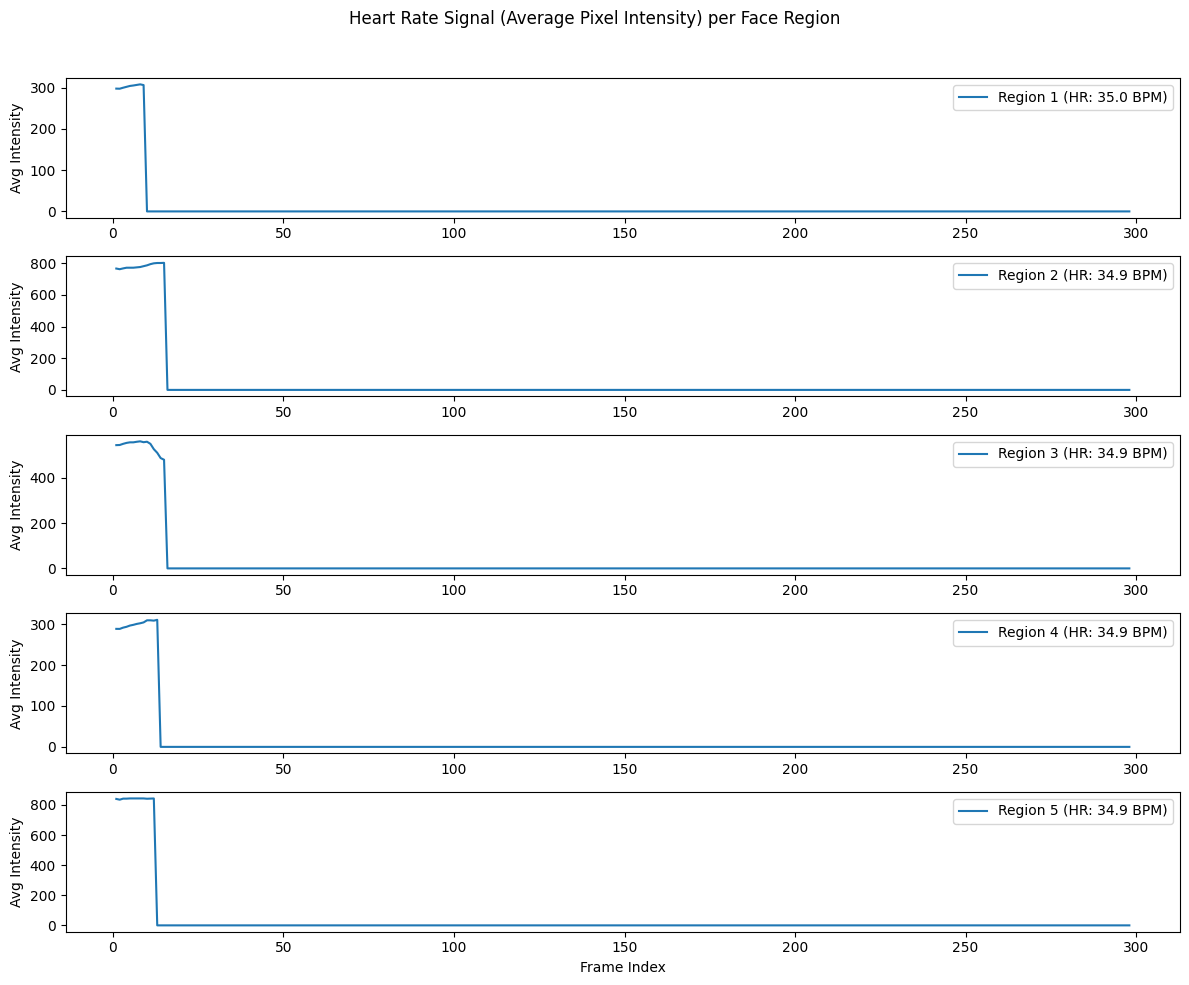

In [ ]:
import numpy as np
import matplotlib.pyplot as plt



# Load the .npy file
# Replace 'your_file.npy' with the actual path to your .npy file
data = np.load('/Users/henryschnieders/Documents/Research/My_work/Current_Summary/Starting_4_5_2025/Data/test415_545_regions.npy', allow_pickle=True)


# ---------------------------
# Helper Functions
# ---------------------------
def complex_mag(x):
    """Return the magnitude of complex value(s)."""
    return np.abs(x)

def signal_process_alter(pix_intensity, fps):
    """
    Process the pixel intensity signal via FFT bandpass filtering between 0.5 Hz and 3.0 Hz
    to estimate the heart rate.
    
    Parameters:
      pix_intensity (1D array): Averaged pixel intensity signal.
      fps (float): Frames per second.
      
    Returns:
      average (float): Estimated heart rate (BPM).
      top5freqs (1D array): Top 5 frequency components (Hz).
    """
    sampling_rate = fps
    lowcut_heart = 0.5
    highcut_heart = 4.0

    N = len(pix_intensity)  # Signal length
    T = 1.0 / sampling_rate  # Sampling interval
    coefs = np.fft.fft(pix_intensity)  # FFT of the signal
    freqs = np.fft.fftfreq(N, T)       # Frequency bins

    # Select frequencies within the heart rate band.
    indices = np.where((np.abs(freqs) >= lowcut_heart) & (np.abs(freqs) <= highcut_heart))
    coefsinrange = coefs[indices]
    freqsinrange = freqs[indices]

    # Select top 5 frequency components based on FFT coefficient magnitude.
    max_indicies = np.argsort(complex_mag(coefsinrange))[-5:]
    coefsinrange = coefsinrange[max_indicies]
    freqsinrange = freqsinrange[max_indicies]

    # Compute a weighted average frequency (Hz) then convert to BPM.
    FFT_heart_rate = np.average(np.abs(freqsinrange), weights=complex_mag(coefsinrange))
    average = FFT_heart_rate * 60

    top5indices = np.argsort(complex_mag(coefsinrange))[-5:]
    top5freqs = freqsinrange[top5indices]

    return average, top5freqs

def motion_process_5regions(data, window_size=10, phi_tol=0.8):
    """
    Process motion for face regions when the input data is organized as:
         data[frame][region]
    For example, if there are T frames and 5 regions per frame, then data is a list of T elements,
    each being a list of 5 images (each image shape: (H, W, 3)).
    
    The function performs temporal normalization using a sliding window, computes frame-to-frame
    differences, and then evaluates a phi value between consecutive difference frames. A phi mask
    (bitmask) is created for each region (for valid frames only) such that a pixel is marked good (1)
    if the phi value is ≥ phi_tol; otherwise 0.
    
    Returns:
      motion_data: A list of length T, where each element is a list of 5 arrays (one per region)
                   of shape (H, W, 3) representing the motion-filtered images.
      phi_bitmask: A list of length T, where each element is a list of 5 phi bitmask arrays (or None)
                   for each region. (A phi mask is computed for frames 1 to T-2; frames 0 and T-1 are None.)
      phi_tol:     The phi tolerance value used.
    """
    T = len(data)
    num_regions = len(data[0])
    
    # ------------------------------------------------
    # Reorganize data per region: each region as a time series.
    # ------------------------------------------------
    regions = []
    for r in range(num_regions):
        # For each region, collect the same region across all frames.
        region_frames = [data[t][r] for t in range(T)]
        regions.append(np.stack(region_frames, axis=0))  # shape (T, H, W, 3)
    
    motion_data_regions = []  # to store motion per region (shape: (T, H, W, 3))
    region_masks_all = []     # to store phi masks for each region (list length T-2 per region)
    
    for region in regions:
        R = region.copy().astype(np.float32)
        # -------------------------------
        # Temporal normalization using a sliding window.
        # -------------------------------
        for t in range(T):
            start = max(0, t - window_size + 1)
            end = t + 1  # window covers frames start...t
            window = R[start:end]
            mean_val = window.mean(axis=(0, 1, 2), keepdims=True)
            std_val = window.std(axis=(0, 1, 2), keepdims=True) + 1e-8
            R[t] = (R[t] - mean_val) / std_val
        
        # -------------------------------
        # Compute motion differences (frame-to-frame differences)
        # -------------------------------
        motion = np.zeros_like(R)
        for t in range(T - 1):
            motion[t] = R[t+1] - R[t]
        # The last frame remains zeros.
        
        # -------------------------------
        # Compute phi masks based on consecutive motion difference frames.
        # The computed phi for a pixel in frame t+1 comes from motion[t] and motion[t+1].
        # We have valid phi values for frames 1 to T-2.
        # -------------------------------
        masks = []
        for t in range(T - 2):
            C_t = motion[t]
            C_t1 = motion[t+1]
            norm_C_t = np.linalg.norm(C_t, axis=-1, keepdims=True) + 1e-8
            norm_C_t1 = np.linalg.norm(C_t1, axis=-1, keepdims=True) + 1e-8
            C_t_normalized = C_t / norm_C_t
            C_t1_normalized = C_t1 / norm_C_t1
            phi = np.sum(C_t_normalized * C_t1_normalized, axis=-1)  # shape: (H, W)
            mask = (phi >= phi_tol).astype(np.uint8)
            masks.append(mask)
            
            # Apply the bitmask to the motion difference in frame t+1.
            expanded_mask = np.expand_dims(mask, axis=-1)
            motion[t+1] = motion[t+1] * expanded_mask
        
        motion_data_regions.append(motion)
        region_masks_all.append(masks)
    
    # ------------------------------------------------
    # Convert per-region outputs back to frame-first indexing.
    # ------------------------------------------------
    # motion_data: list with length T; each element is a list of 5 regions' motion data.
    motion_data = []
    for t in range(T):
        frame_motion = []
        for r in range(num_regions):
            frame_motion.append(motion_data_regions[r][t])
        motion_data.append(frame_motion)
    
    # phi_bitmask: create a list of length T where each element is a list of 5 phi masks.
    # Valid phi masks are available for frames 1 to T-2. For frames 0 and T-1, store None.
    phi_bitmask = []
    for t in range(T):
        frame_masks = []
        for r in range(num_regions):
            if 1 <= t < T - 1:
                # The mask for frame t is stored at index t-1 in the region's mask list.
                frame_masks.append(region_masks_all[r][t - 1])
            else:
                frame_masks.append(None)
        phi_bitmask.append(frame_masks)
    
    return motion_data, phi_bitmask, phi_tol

# ---------------------------
# Driver Code
# ---------------------------
def main():
    # --- Simulation parameters ---
    fps = 30            # frames per second
    T = len(data)      # total number of frames in each video region
    num_regions = 5     # e.g., 5 face regions per frame


    # --- Compute motion data and phi bitmask ---
    motion_data, phi_bitmask, used_phi_tol = motion_process_5regions(data, window_size=10, phi_tol=0.8)
    
    # --- Build the average pixel intensity signal per face region ---
    # For each frame with a valid phi mask (frames 1 to T-2), compute the average pixel intensity
    # over the "good" pixels (those with mask value 1) for each region.
    region_signals = [[] for _ in range(num_regions)]
    
    for t in range(T):
        for r in range(num_regions):
            mask = phi_bitmask[t][r]
            if mask is not None:
                # Get the corresponding original frame for face region r.
                frame = data[t][r]
                # Convert to grayscale by averaging the three channels.
                gray_frame = np.mean(frame, axis=-1)
                # Select only the "good" pixels (mask == 1).
                good_pixels = gray_frame[mask == 1]
                if good_pixels.size > 0:
                    avg_intensity = np.mean(good_pixels)
                else:
                    avg_intensity = 0
                region_signals[r].append(avg_intensity)
            else:
                # For frames without a valid phi mask, store NaN.
                region_signals[r].append(np.nan)
    
    # Convert each region's signal to a NumPy array.
    region_signals = [np.array(signal) for signal in region_signals]
    
    # --- Process the intensity signals to compute heart rate per region ---
    region_heart_rates = []
    for r in range(num_regions):
        # Remove NaN values from the signal.
        valid_signal = region_signals[r][~np.isnan(region_signals[r])]
        if len(valid_signal) > 0:
            hr, top5freqs = signal_process_alter(valid_signal, fps)
        else:
            hr, top5freqs = 0, np.array([])
        region_heart_rates.append(hr)
        print(f"Region {r+1}: Estimated Heart Rate = {hr:.2f} BPM, Top Frequencies (Hz) = {top5freqs}")
    
    # --- Plot the heart rate (average intensity) signal for each region ---
    plt.figure(figsize=(12, 10))
    for r in range(num_regions):
        plt.subplot(num_regions, 1, r+1)
        plt.plot(region_signals[r], label=f"Region {r+1} (HR: {region_heart_rates[r]:.1f} BPM)")
        plt.ylabel("Avg Intensity")
        plt.legend(loc="upper right")
        if r == num_regions - 1:
            plt.xlabel("Frame Index")
    plt.suptitle("Heart Rate Signal (Average Pixel Intensity) per Face Region")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

if __name__ == "__main__":
    main()
